# Health Insurance Dataset
### Objective
-  Supervised Learning (Binary Classification problem). Predict whether the policyholders (customers) from the previous year will also be interested in Vehicle Insurance provided by the company.


## 1. DATA COLLECTION 
- Collect the data from kaggle with CSV format

## 2. EXPLORATORY DATA ANALYSIS & DATA CLEANING
- Statiscial summary on numerical features and objects 
- Dataset shape
- Datatypes (numerical, categorical)
- Categorical (ordinal and nominal)
- Pearson Correlation
- Target values visualization 
- Plot Distribution 
- Check for Imbalanced Dataset

## 3. FEATURE ENGINEERING
- Find outliers
- Fill Missing Values 
- Binary Classification Problem 
- Ordinal and Label Encode
- If model is tree based method (Decesion Tree, Random Forest, XGBoost), no scaling is needed 


## 4. FEATURE SELECTION
- Dropping low variance features 
- Information Gain-Mutual Information in Classification Problems
- Pearson Correlation 
- Fisher Score-ChiSquare Test for Feature Selection
- Tree-based Selection using ExtraTreesClassifier (Feature Importance)
- Univariate Selection 


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pylab
from pprint import pprint
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss

# DATA COLLECTION 
- importing files

In [2]:
train = pd.read_csv('../inputs/train.csv')
test = pd.read_csv('../inputs/test.csv')
sample = pd.read_csv('../inputs/sample_submission.csv')
print(f'Training shape: {train.shape}, Testing Shape: {test.shape}, Sample Shape: {sample.shape}')

Training shape: (381109, 12), Testing Shape: (127037, 11), Sample Shape: (127037, 2)


In [3]:
# define the index id and join test with sample dataframe
test = test.set_index('id').join(sample.set_index('id'))
df = train.set_index('id')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# EXPLORATORY DATA ANALYSIS & DATA CLEANING
- Statiscial summary on numerical features and objects 
- Dataset shape
- Datatypes (numerical, categorical)
- Categorical (ordinal and nominal)
- Pearson Correlation
- Target values visualization 
- Plot Distribution 
- Check for Imbalanced Dataset

In [4]:
# find null values in DataFrame
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Data is Clean, No Null values found


In [5]:
# explore the shape (rows and columns) for dataframe
print(f'Number of rows of DataFrame: {df.shape[0]}')
print(f'Number of columns of DataFrame: {df.shape[1]}')

Number of rows of DataFrame: 381109
Number of columns of DataFrame: 11


In [6]:
features = df.columns
numerical_feat = [features for features in df.columns if df[features].dtypes != 'O']
print(f'Number of Numerical Features: {len(numerical_feat)}')

categorical_feat = [features for features in df.columns if df[features].dtypes == 'O']
print(f'Number of Categorical Features: {len(categorical_feat)}')

Number of Numerical Features: 8
Number of Categorical Features: 3


In [7]:
pprint(df.columns.to_series().groupby(df.dtypes).groups)

{dtype('int64'): Index(['Age', 'Driving_License', 'Previously_Insured', 'Vintage', 'Response'], dtype='object'),
 dtype('float64'): Index(['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel'], dtype='object'),
 dtype('O'): Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')}


In [8]:
# statisical summary for quantitative columns 
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [9]:
# statistical summary of object dtypes columns (categorical)
df.describe(include=[np.object])

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


In [10]:
pct_response = (df.Response.value_counts()[1] /  df.Response.value_counts()[0]) *100
print(f'Percentage of Customers that are Interested {pct_response:0.2f}%')

Percentage of Customers that are Interested 13.97%


In [11]:
def plot_distribution(dataframe, feature):
	plt.figure(figsize=(25,6))
	# first row, 1st column
	plt.subplot(1, 3, 1)
	sns.histplot(dataframe[feature])
	# first row, 2nd column
	plt.subplot(1, 3, 2)
	stats.probplot(dataframe[feature], dist='norm', plot=pylab)
 	# first row, 3rd column
	plt.subplot(1, 3, 3)
	sns.boxplot(dataframe[feature], orient="h", palette="Set2")
	plt.show()

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


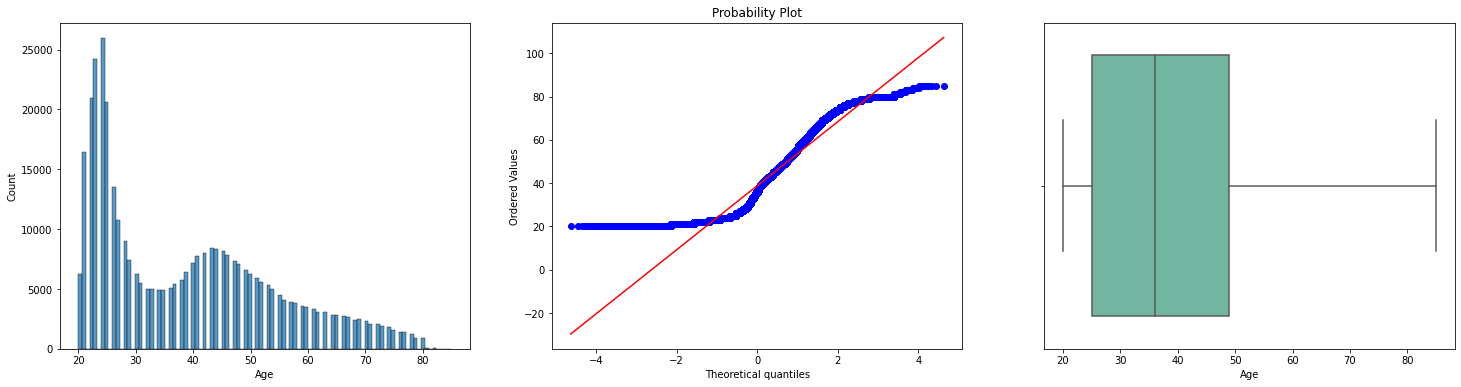

In [12]:
plot_distribution(df, 'Age')

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


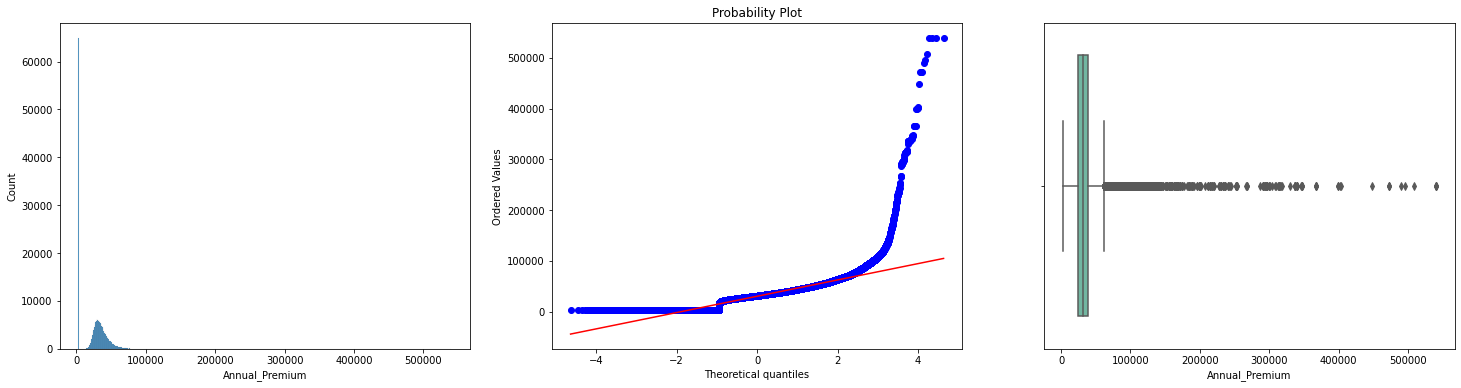

30564.389581458323


In [13]:
# Annual Premium has outliers as shown in the boxplot 
plot_distribution(df, 'Annual_Premium')
print(df.Annual_Premium.mean())

<AxesSubplot:title={'center':'Count of Interest or Not'}, xlabel='Response', ylabel='count'>

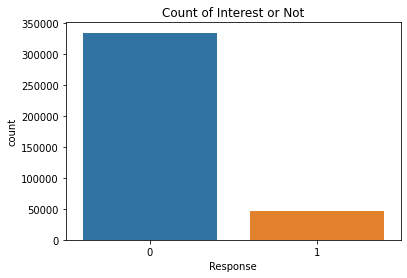

In [14]:
# 1 : Customer is interested, 0 : Customer is not interested
plt.title("Count of Interest or Not")
sns.countplot(x = "Response", data=df)

<AxesSubplot:title={'center':'Response based on Vehicle Damage'}, xlabel='Response', ylabel='count'>

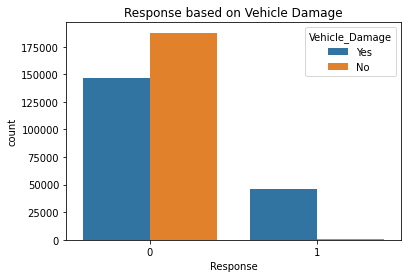

In [15]:

plt.title("Response based on Vehicle Damage")
sns.countplot(x = "Response", hue = 'Vehicle_Damage', data=df)
# Customer with their vehicle damaged in the past tend to be interested

<AxesSubplot:title={'center':'Response based on Previosly Insured'}, xlabel='Response', ylabel='count'>

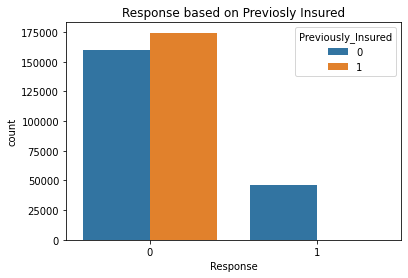

In [16]:
plt.title("Response based on Previosly Insured")
sns.countplot(x = "Response", hue = 'Previously_Insured', data=df)

<AxesSubplot:title={'center':'Response based on Vehicle Age'}, xlabel='Response', ylabel='count'>

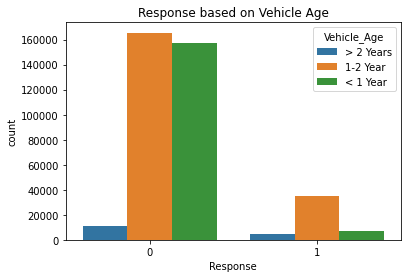

In [17]:
plt.title("Response based on Vehicle Age")
sns.countplot(x = "Response", hue = 'Vehicle_Age', data=df)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Response based on Gender Category'}, xlabel='Gender', ylabel='count'>

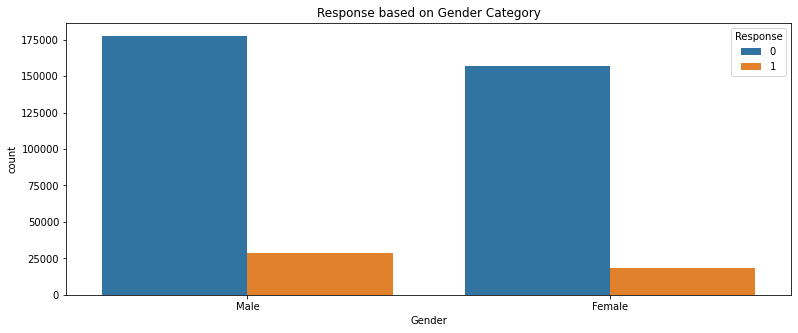

In [18]:
plt.figure(figsize = (13,5))
plt.title("Response based on Gender Category")
sns.countplot(df['Gender'], hue = df['Response'])

<AxesSubplot:>

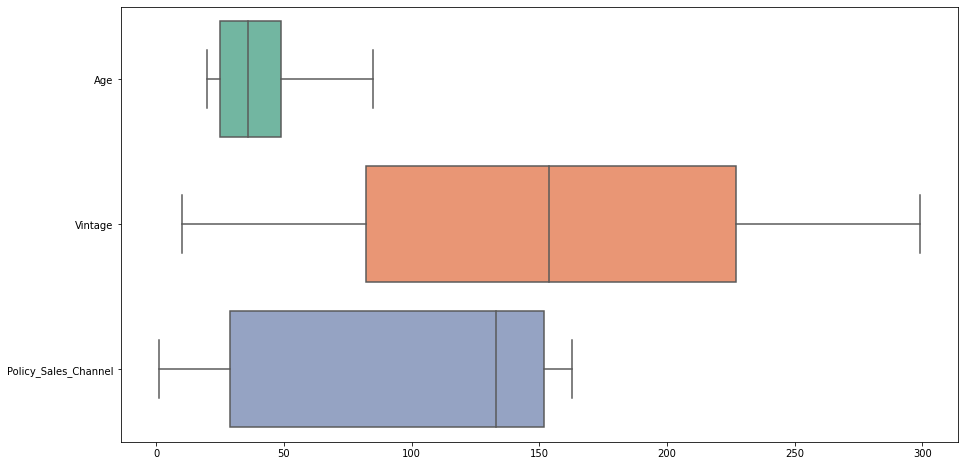

In [19]:
null_col = ['Age', 'Vintage','Policy_Sales_Channel']
plt.subplots(figsize=(15,8))
sns.boxplot(data=df[null_col], orient="h", palette="Set2")
# no outliers found 

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


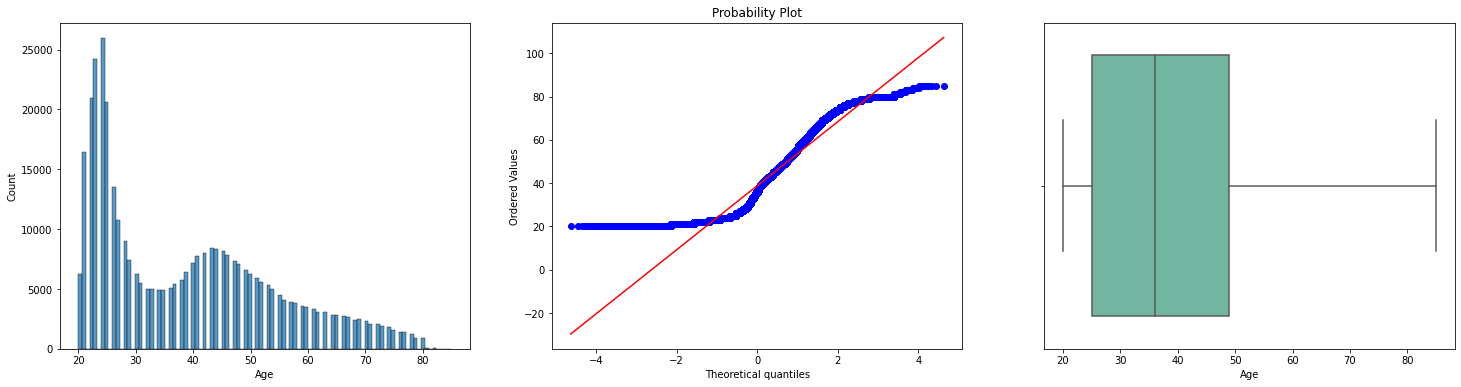

In [20]:
plot_distribution(df, 'Age')

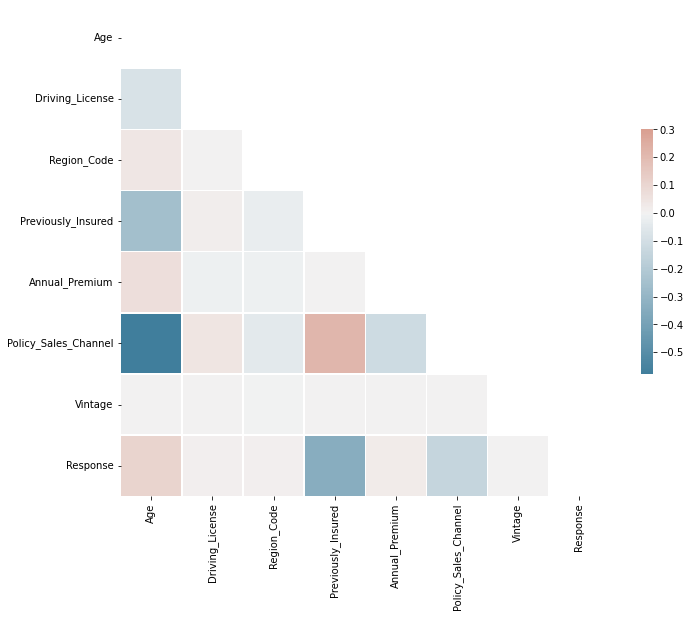

In [21]:
# plot correlation 
def pearson_corr(dataframe):
    # compute corr array and generate a mask for the upper triangle
    corr = dataframe.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # plt heatmap with mask and ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
pearson_corr(df)   

# FEATURE ENGINEERING
- Find outliers
- Fill Missing Values 
- Binary Classification Problem 
- Ordinal and Label Encode
- If model is tree based method (Decesion Tree, Random Forest, XGBoost), no scaling is needed 


In [22]:
# get each categorical features
# get each class name 
cat_features = df[['Gender', 'Vehicle_Age', 'Vehicle_Damage']]

# printing unique values of each column
for col in cat_features.columns:
    print(f"{col}: {cat_features[col].unique()}")

Gender: ['Male' 'Female']
Vehicle_Age: ['> 2 Years' '1-2 Year' '< 1 Year']
Vehicle_Damage: ['Yes' 'No']


## Nominal and Ordinal 

In [23]:
nominal_col = ['Gender', 'Vehicle_Damage']
df[nominal_col] = df[nominal_col].apply(LabelEncoder().fit_transform)

In [24]:
vehicle_age_map = {'< 1 Year':1, '1-2 Year':2, '> 2 Years':3}
df['Vehicle_Age'] = df.Vehicle_Age.map(vehicle_age_map)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


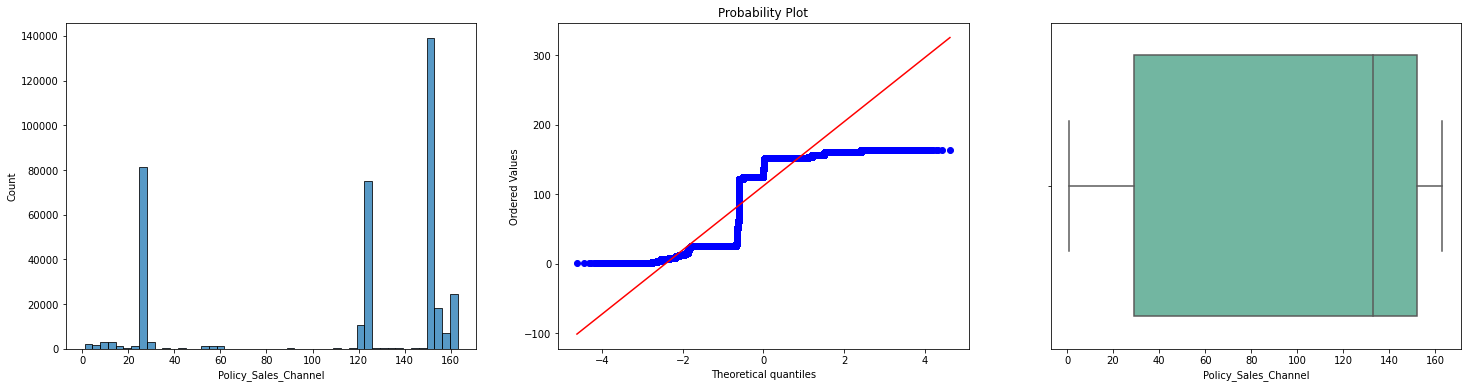

In [25]:
# Annual Premium has outliers as shown in the boxplot 
plot_distribution(df, 'Policy_Sales_Channel')

In [26]:
replacements = {
    'int64': 'int',
    'float64': 'float'
}
col_str = ", ".join('{} {}'.format(n,d) for (n,d) in zip(df.columns, df.dtypes.replace(replacements)))

In [27]:
# find null values in DataFrame
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Data is Clean, No Null values found


# Detect Outliers 

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


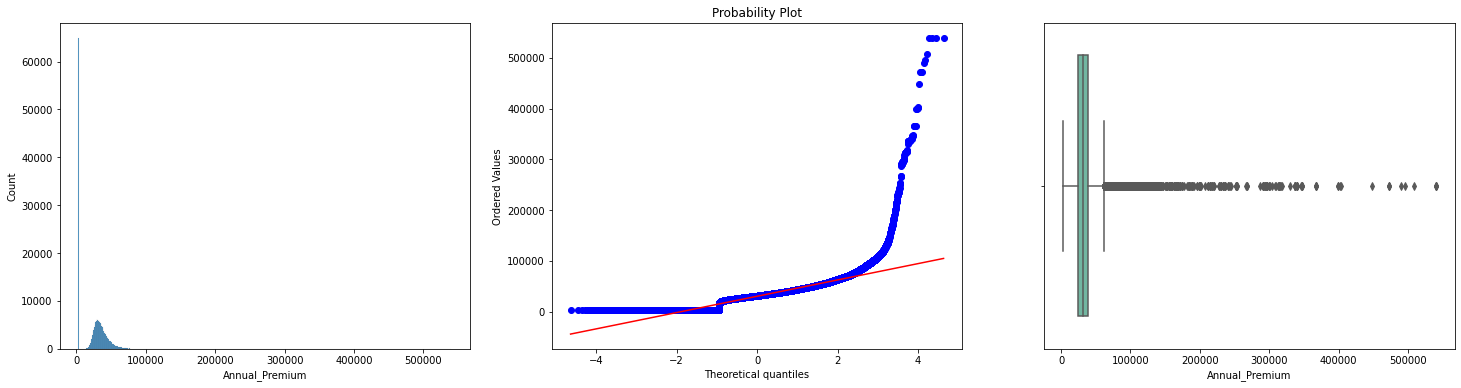

In [28]:
plot_distribution(df, 'Annual_Premium')

In [29]:
# filter out outliers that are greater than 3 std from mean
outliers = []
def detect_outliers(col):
    mu = np.mean(col)
    std = np.std(col)
    
    for i in col:
        z_score = (i - mu)/ std
        if np.abs(z_score) > 3:
            outliers.append(i)
    return outliers
    
outlier_pt = detect_outliers(df.Annual_Premium)
outliers = df.shape[0]
df = df[~df.Annual_Premium.isin(outlier_pt)]
no_outliers = df.shape[0]
print(f'Total Outliers: {outliers-no_outliers}')

Total Outliers: 2083


/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


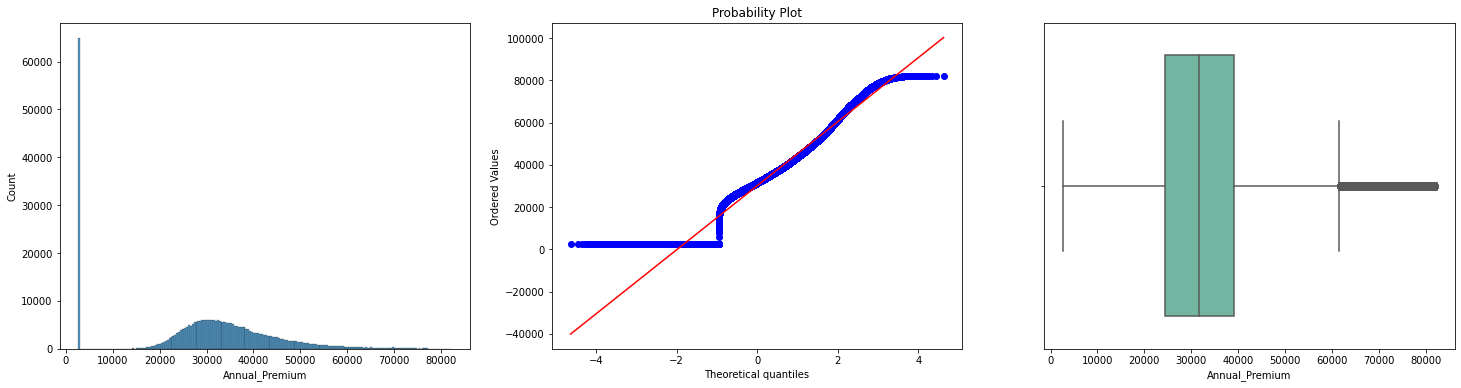

In [30]:
plot_distribution(df, 'Annual_Premium')

# FEATURE SELECTION
- Dropping low variance features 5%>
- Information Gain-Mutual Information in Classification Problems
- Pearson Correlation 
- Fisher Score-ChiSquare Test for Feature Selection
- Tree-based Selection using ExtraTreesClassifier (Feature Importance)
- Univariate Selection 

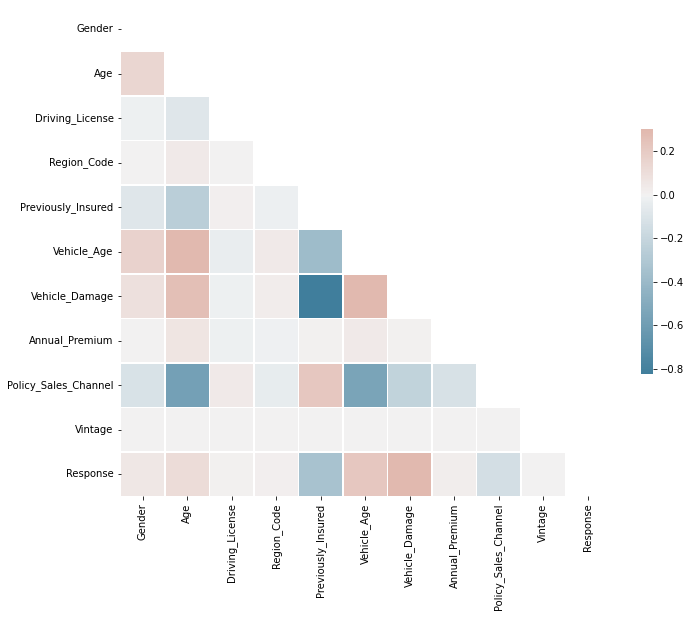

In [31]:
pearson_corr(df)   

In [32]:
var_threshold = VarianceThreshold(threshold=0.05)
var_threshold.fit(df)

# get the number of feature coumns with 0 variance 
constant_col = [col for col in df.columns if col not in df.columns[var_threshold.get_support()]]
# drop feature with 0 variance (constanct features) 
print(constant_col)
df.drop(constant_col, axis=1, inplace=True)

['Driving_License']


In [33]:
targets = df.Response
features = df.drop('Response', axis=1)

<AxesSubplot:>

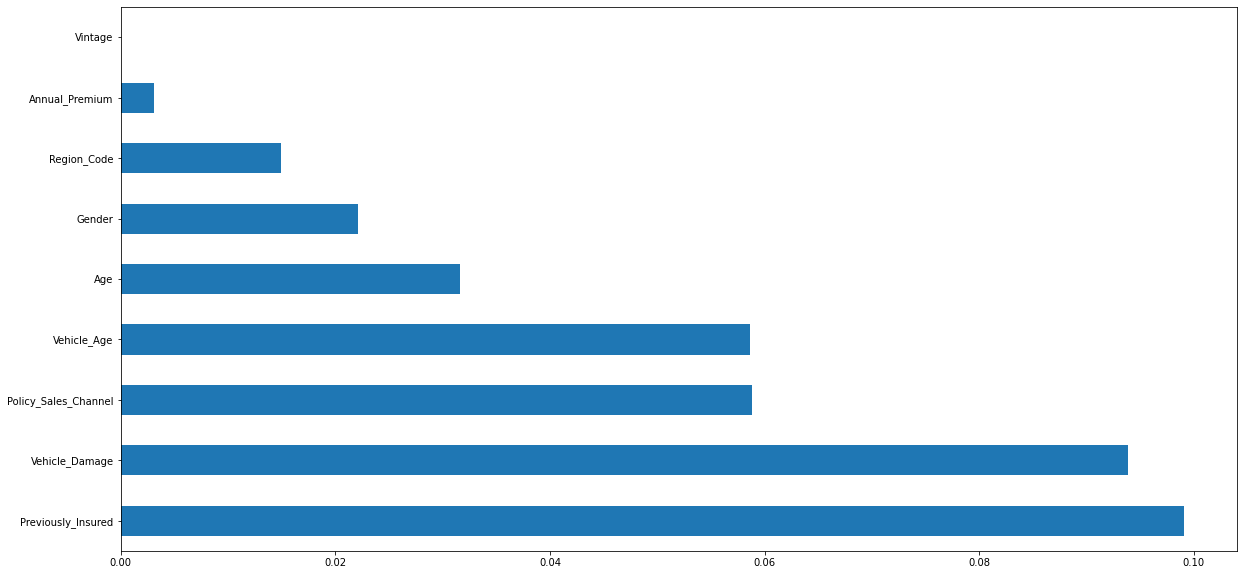

In [34]:
# determine the mutual information for classification 
# output a value between [0,1], the higher the value the more dependent on target values
mutual_info = mutual_info_classif(features, targets)
# convert into series and get column names 
mutual_info = pd.Series(mutual_info)
mutual_info.index = features.columns

# plot ordered mutual_info values per feature 
mutual_info.sort_values(ascending=False).plot(kind='barh', figsize=(20,10))

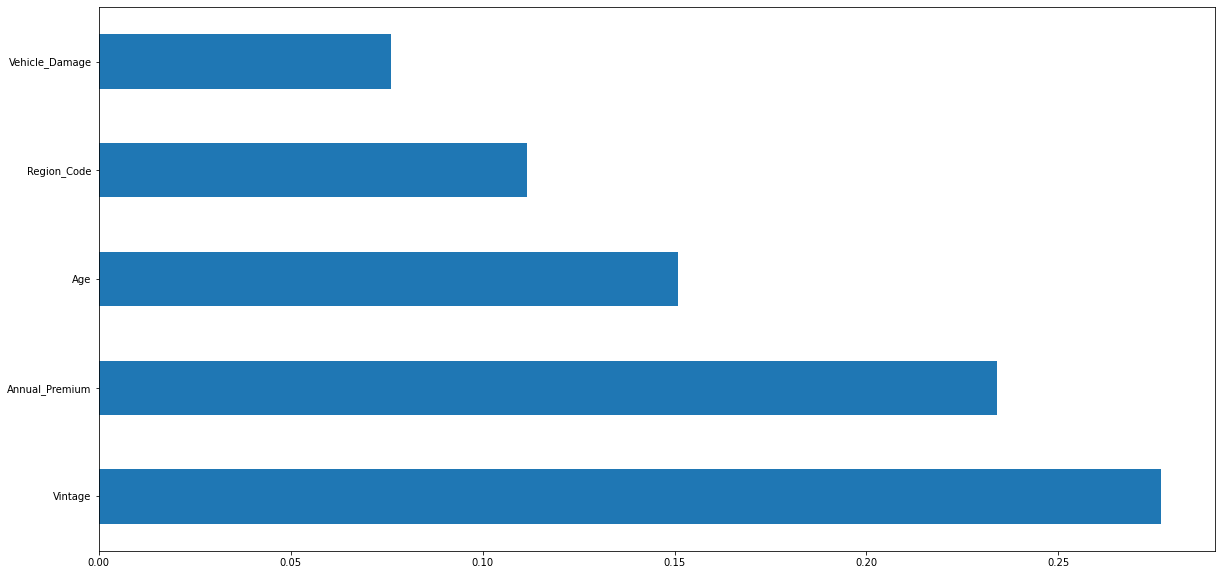

In [36]:
model = ExtraTreesClassifier()
model.fit(features, targets)

# plot the feature importance
feat_importance = pd.Series(model.feature_importances_, index = features.columns)
feat_importance.nlargest(5).plot(kind='barh', figsize=(20,10))
plt.show()

<AxesSubplot:>

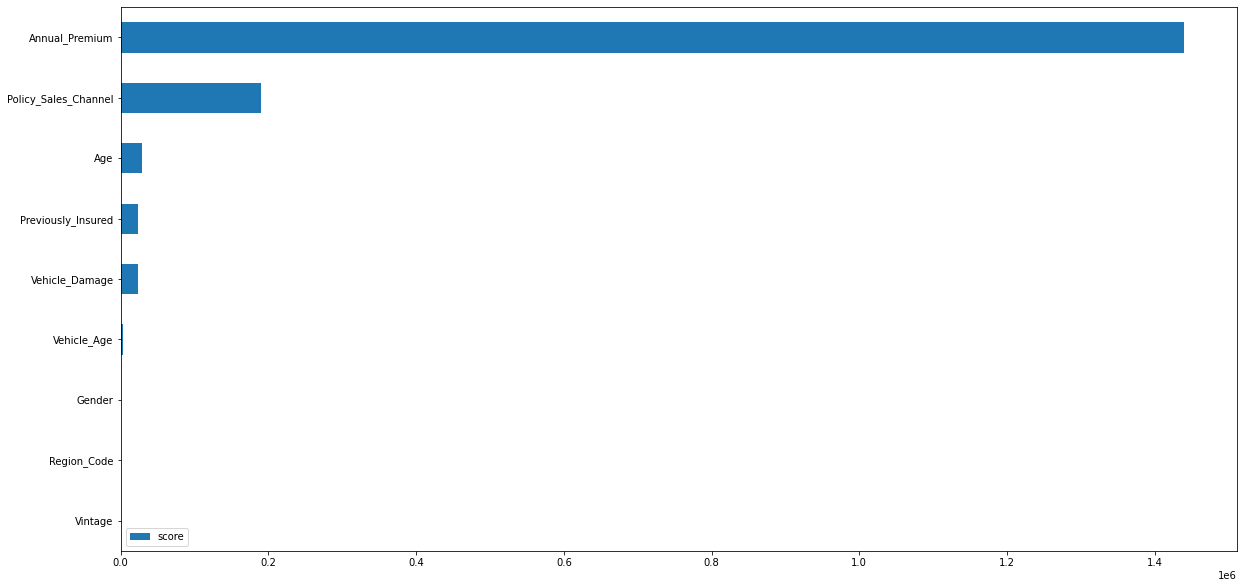

In [38]:
# get top 5 features using Chi2
best_features = SelectKBest(score_func=chi2, k=5)
fit = best_features.fit(features, targets) 

# get a dataframe of score and column names
df_scores = pd.DataFrame(fit.scores_)
df_col = pd.DataFrame(features.columns)

# concat borth dataframes
feat_scores = pd.concat([df_col, df_scores], axis=1)
feat_scores.columns = ['features', 'score']
feat_scores.index = features.columns
feat_scores.sort_values(by='score').plot(kind='barh', figsize=(20,10))

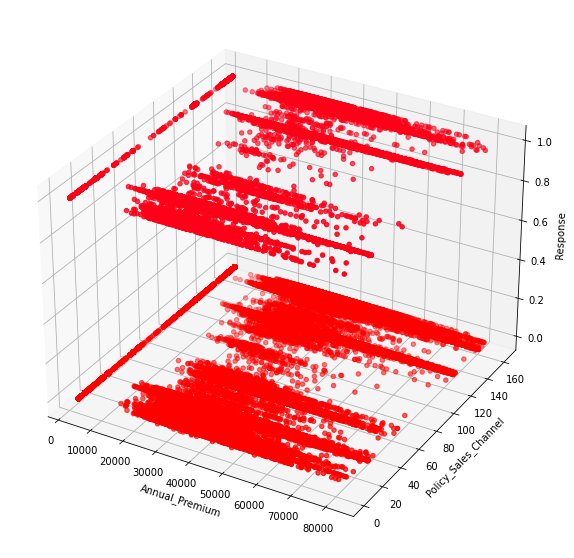

In [39]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection="3d")

x_points = df['Annual_Premium']
y_points = df['Policy_Sales_Channel']
z_points = df['Response']
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv')

ax.set_xlabel('Annual_Premium')
ax.set_ylabel('Policy_Sales_Channel')
ax.set_zlabel('Response')
plt.show()

In [40]:
df.to_csv('../inputs/health_insurance_clean.csv', index=False)

# IMBALANCED DATASET 

### 14% of target values are interested

# How to deal with Imbalanced Dataset 
- Stratified KFold

In [41]:
pct_response = (df.Response.value_counts()[1] /  df.Response.value_counts()[0]) *100
print(f'Percentage of Customers that are Interested {pct_response:0.2f}%')

Percentage of Customers that are Interested 13.95%


In [42]:
## Get interested and not_interested count values
interested = df[df['Response']==1]
not_interested = df[df['Response']==0]
print(interested.shape)
print(not_interested.shape)

targets = df['Response']
features = df.drop('Response', axis=1)

# Implementing Undersampling for Handling Imbalanced 
nm = NearMiss()
features_res, targets_res = nm.fit_resample(features,targets)

(46388, 10)
(332638, 10)


In [43]:
print(f'Original dataset shape {Counter(targets)}')
print(f'Resampled dataset shape {Counter(targets_res)}')

Original dataset shape Counter({0: 332638, 1: 46388})
Resampled dataset shape Counter({0: 46388, 1: 46388})
